### EXAMEN - Convocatoria 1 - Programación
Utilizar el conjunto de datos "dataset_exam.npy" para resolver el ejercicio. Tener en cuenta que la última columna corresponde a la clase.

## Importaciones

Se sigue un poco la filosofía de los notebooks de prácticas, importando las librerías necesarias en la primera celda.

In [102]:
# Si falta alguna dependencia descomentar siguiente linea
# !pip install numpy scikit-learn pandas matplotlib seaborn

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import sklearn.metrics as metrics
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#### 1) Partición de datos externa (1 punto)
Realizar una partición externa de tipo hold-out seleccionando un 20% de los datos para test (fijar una semilla en 42).
Comprobad si los datos, tanto de train como de test, están más o menos balanceados.

In [103]:
RANDOM_STATE=42

# Cargamos los datos 
data = np.load('dataset_exam.npy', allow_pickle=True)

print(f"El conjunto de datos inicial tiene {data.shape[0]} muestras y {data.shape[1]} características.")
features, target = data[:,:-1], data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=RANDOM_STATE, stratify=target)

y_train_counts = np.unique(y_train, return_counts=True)
y_test_counts = np.unique(y_test, return_counts=True)

print(f"En conjunto train hay {y_train_counts[1][0]} de la clase {y_train_counts[0][0]} y {y_train_counts[1][1]} de la clase {y_train_counts[0][1]}")
print(f"En conjunto test hay {y_test_counts[1][0]} de la clase {y_test_counts[0][0]} y {y_test_counts[1][1]} de la clase {y_test_counts[0][1]}")

El conjunto de datos inicial tiene 492 muestras y 9 características.
En conjunto train hay 196 de la clase 0.0 y 197 de la clase 1.0
En conjunto test hay 50 de la clase 0.0 y 49 de la clase 1.0


**Conclusiones:** Inicialmente el balanceo entre clases era bastante bueno sin usar estratificación, pero al usar estratificación se mejora aún más el balanceo en los conjuntos de entrenamiento y prueba.

#### 2) Estandarización de los datos de train y test (1 punto)
Utilizar el método StandardScaler().

In [104]:
standardizer = StandardScaler()

COL_NUM = 2
print("ANTES DE LA ESTANDARIZACIÓN:")
print(f"Columna {COL_NUM} - Train: mean={X_train[:,COL_NUM].mean():.3f}, std={X_train[:,COL_NUM].std():.3f}")
print(f"Columna {COL_NUM} - Test:  mean={X_test[:,COL_NUM].mean():.3f}, std={X_test[:,COL_NUM].std():.3f}")

X_train_standarized = standardizer.fit_transform(X_train)

X_test_standarized = standardizer.transform(X_test)

print("\nDESPUÉS DE LA ESTANDARIZACIÓN:")
print(f"Columna {COL_NUM} - Train: mean={X_train_standarized[:,COL_NUM].mean():.3f}, std={X_train_standarized[:,COL_NUM].std():.3f}")
print(f"Columna {COL_NUM} - Test:  mean={X_test_standarized[:,COL_NUM].mean():.3f}, std={X_test_standarized[:,COL_NUM].std():.3f}")

ANTES DE LA ESTANDARIZACIÓN:
Columna 2 - Train: mean=1.372, std=1.119
Columna 2 - Test:  mean=1.455, std=1.076

DESPUÉS DE LA ESTANDARIZACIÓN:
Columna 2 - Train: mean=-0.000, std=1.000
Columna 2 - Test:  mean=0.074, std=0.962


En este caso hemos decidido seleccionar una columna para mostrar la transformación de los datos antes y después de la estandarización. Como se puede apreciar hemos transformado la distribución de los datos para que tengan una desviación típica y media determinada.

#### 3) Selección de atributos en train y test (1 punto)
Aplicar el método de mutual information para clasificación seleccionando un percentile=90. (Recordad la función "SelectPercentile")

In [105]:
selectPercentile = SelectPercentile(score_func=lambda X, y: mutual_info_classif(X, y, random_state=RANDOM_STATE), percentile=90)

final_X_train = selectPercentile.fit_transform(X_train_standarized, y_train)
final_X_test = selectPercentile.transform(X_test_standarized)

selected_features = selectPercentile.get_support()
maintained_cols = [i for i, selected in enumerate(selected_features) if selected]
eliminated_cols = [i for i, selected in enumerate(selected_features) if not selected]

print(f"Se mantienen las columnas con índices: {maintained_cols}")
print(f"Se eliminan las columnas con índices: {eliminated_cols}")

print("Características seleccionadas:", selected_features)
print(f"Se han pasado de {X_train_standarized.shape[1]} a {final_X_train.shape[1]} características tras la selección de características en el conjunto de training.")
print(f"Se han pasado de {X_test_standarized.shape[1]} a {final_X_test.shape[1]} características tras la selección de características en el conjunto de test.")

Se mantienen las columnas con índices: [0, 1, 2, 3, 5, 6, 7]
Se eliminan las columnas con índices: [4]
Características seleccionadas: [ True  True  True  True False  True  True  True]
Se han pasado de 8 a 7 características tras la selección de características en el conjunto de training.
Se han pasado de 8 a 7 características tras la selección de características en el conjunto de test.


**Conclusiones**: Se ha añadido una función lambda para fijar la semilla y asegurar la reproducibilidad de los resultados. Había una componente aleatoria en la función mutual_info_classif que podía llevar a resultados diferentes en distintas ejecuciones.

#### 4) Comparación de modelos de clasificación mediante validación cruzada (3 puntos)
Instrucciones:

- Aplicar una validación cruzada interna de K=5 bolsas para optimizar y comparar la capacidad predictiva de los siguientes modelos: Regresión Logística y Support Vector Machine.
- La optimización de hiperparámetros debe realizarse de manera automática. (Recordad la función "GridSearchCV").
- La comparación debe realizarse únicamente en términos de exactitud proporcionando resultados de media +- desviación estándar.

In [106]:
K_FOLDS = 5

models = {
    'LOGR': {
        'model': LogisticRegression(random_state=RANDOM_STATE),
        'params': [
            {'penalty': ['l1', 'l2',], 'solver': ['saga'], 'C': [0.1, 0.5, 1, 10]},
            {'penalty': ['l2'], 'solver': ['lbfgs']},
            {'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': [0.1, 0.5, 1]},
            {'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.5, 0.9], 'C': [0.1, 0.5, 1, 10]},
            {'penalty': [None], 'solver': ['saga'], }
        ]
    },
    'SVM': {
        'model': SVC(random_state=RANDOM_STATE),
         'params': [
            {'C': [0.1, 0.5, 1, 5, 10, 50, 100], 'kernel': ['rbf'], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1, 10]},
            {'C': [0.01, 0.1, 0.5, 1, 5, 10, 50, 100], 'kernel': ['linear']}
         ]
    }
}

results = {}

for name, config in models.items():
    grid = GridSearchCV(config['model'], config['params'], cv=K_FOLDS, scoring='accuracy')
    grid.fit(final_X_train, y_train)
    results[name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'cv_scores': grid.cv_results_['mean_test_score'],
        'cv_std': grid.cv_results_['std_test_score']
    }

    print(f"\n{name}:")
    print(f"  Mejor accuracy: {grid.best_score_:.4f} ± {grid.cv_results_['std_test_score'][grid.best_index_]:.4f}")
    print(f"  Mejores hiperparámetros: {grid.best_params_}")


LOGR:
  Mejor accuracy: 0.7252 ± 0.0186
  Mejores hiperparámetros: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

SVM:
  Mejor accuracy: 0.8319 ± 0.0407
  Mejores hiperparámetros: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}


Si tomamos como fuente: https://www.digitalocean.com/community/tutorials/logistic-regression-with-scikit-learn podemos obtener la siguiente tabla:

| Solver     | Regularization Supported     | Best Use Case                                       | Limitations                                                                 |
|-------------|------------------------------|-----------------------------------------------------|------------------------------------------------------------------------------|
| **liblinear** | L1, L2                       | Sparse data; suitable for small datasets.           | Inefficient for dense data or unscaled datasets; may struggle with large C values. |
| **lbfgs**     | L2                           | Medium to large datasets, especially dense ones.    | Memory-intensive for very large data.                                       |
| **saga**   | L1, L2, Elastic Net           | Large-scale or high-dimensional problem.            | Performance depends on proper scaling; resource-intensive for some cases.   |



En este caso, si tomamos como referencia la anterior tabla, odemos concluir que nuestra función para regresión logística sería "liblinear" dado que es ideal para datasets pequeños, sin embargo, como tanto el coste computacional como desarrollo de software es muy bajo si se tienen en cuenta todos los casos, se ha preferido usar los 3 modelos con diferentes configuraciones para tener un barrido más completo de las posibilidades.

#### 5) Evaluación de los modelos sobre el conjunto de test (2.5 puntos)
- Entrenar los modelos anteriores utilizando todos los datos de entrenamiento.
- Evaluar su rendimiento sobre el conjunto de test mostrando una tabla de resultados tal que:
 * Las filas serán: Precisión, Sensibilidad, F-score, Exactitud y AUC
 * Las columnas serán: LOGR y SVM

In [107]:
final_models = {}

for name, model_results in results.items():
    if name == 'LOGR':
        final_model = LogisticRegression(random_state=RANDOM_STATE, **model_results['best_params'])
    elif name == 'SVM':
        # Se inserta probabiliity para calcular AUC dmas tardes
        final_model = SVC(random_state=RANDOM_STATE, probability=True, **model_results['best_params'])
    
    final_model.fit(final_X_train, y_train)
    final_models[name] = final_model

evaluation_results = {}
for name, model in final_models.items():
    y_pred = model.predict(final_X_test)
    y_proba = model.predict_proba(final_X_test)[:, 1]
    
    evaluation_results[name] = {
        'Precisioonn': metrics.precision_score(y_test, y_pred),
        'Sensibilidad': metrics.recall_score(y_test, y_pred),
        'F1-score': metrics.f1_score(y_test, y_pred),
        'Exactitud': metrics.accuracy_score(y_test, y_pred),
        'AUC': metrics.roc_auc_score(y_test, y_proba)
    }

df_results = pd.DataFrame(evaluation_results)
print(df_results.round(4))

                LOGR     SVM
Precisioonn   0.6383  0.8718
Sensibilidad  0.6122  0.6939
F1-score      0.6250  0.7727
Exactitud     0.6364  0.7980
AUC           0.7069  0.8853


#### 6) Visualización de resultados (1 punto)
- Mostrar la matriz de confusión


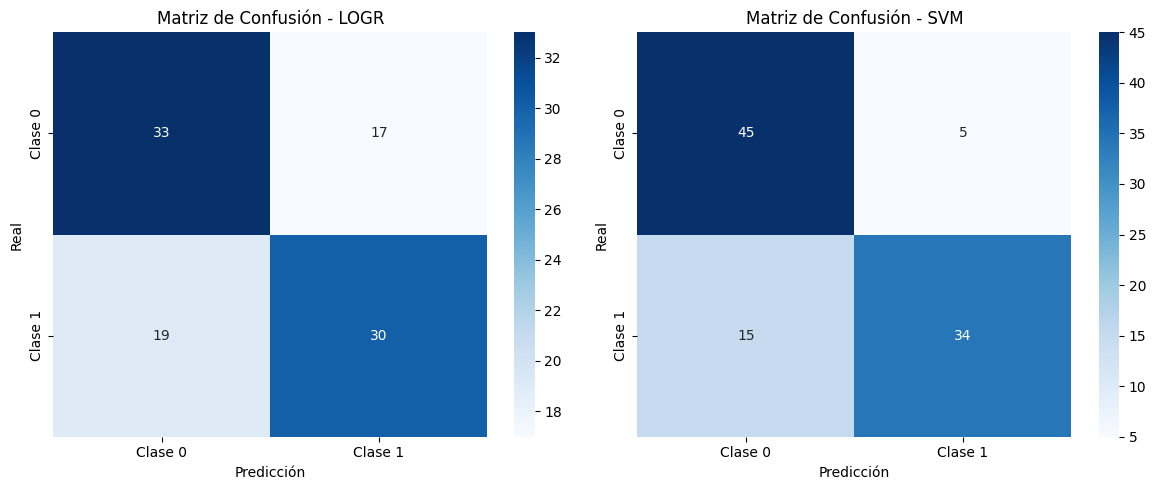

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for i, (name, model) in enumerate(final_models.items()):
    y_pred = model.predict(final_X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Clase 0', 'Clase 1'], 
                yticklabels=['Clase 0', 'Clase 1'],
                ax=axes[i])
    axes[i].set_title(f'Matriz de Confusión - {name}')
    axes[i].set_xlabel('Predicción')
    axes[i].set_ylabel('Real')

plt.tight_layout()
plt.show()

- **Mostrar en una única figura la comparación de las curvas ROC obtenidas por cada modelo. (Recordad que SVM requiere un parámetro específico en su llamada para poder calcular la curva ROC).**

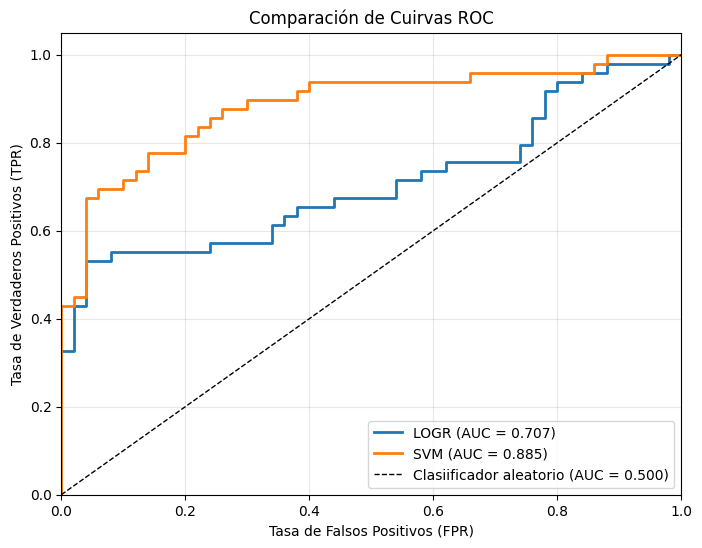

In [109]:
plt.figure(figsize=(8, 6))

for name, model in final_models.items():
    y_proba = model.predict_proba(final_X_test)[:, 1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
    auc = metrics.roc_auc_score(y_test, y_proba)
    
    plt.plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Clasiificador aleatorio (AUC = 0.500)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Comparación de Cuirvas ROC')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

#### 7) Interpretación de resultados (0.5 puntos)
* **Justifica brevemente cuál de los dos modelos utilizarías para ponerlo en producción**

Desde mi punto de vista, la métrica que mejor nos puede orientar para tomar una decisión es la AUC, ya que nos da una idea de la capacidad del modelo para discriminar entre clases. En este caso, el modelo SVM tiene una AUC superior a la del modelo de Regresión Logística (0.8717 frente a 0.7439). Esto indica que el modelo SVM tiene una mejor capacidad para distinguir entre las clases positivas y negativas en comparación con la Regresión Logística.

Adicionalmente, si nos fijamos en las otras métricass como Precisión, Sensibilidad y F-score, el modelo SVM también supera a la Regresión Logística en todas ellas. Esto refuerza la idea de que el modelo SVM es más efectivo en este caso particular.